In [ ]:
from IPython.utils.io import capture_output
with capture_output() as captured:
    ! pip install import_ipynb
    ! pip install tensorflow==2.15.0
    ! pip install boto3
    ! pip install pandas
    ! pip install librosa
    ! pip install soundfile
    ! pip install opencv-contrib-python
    ! pip install tensorflow_probability==0.23.0
    ! pip install scikit-maad
    ! pip install tensorflow_addons==0.23.0
    ! pip install wave

In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.utils.io import capture_output
from IPython.display import clear_output

import sys
sys.path.append('/opt/anaconda3/lib/python3.11/site-packages')

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Dense, Lambda
import tensorflow_probability as tfp
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from scipy import stats
from PIL import ImageColor, ImageFont
import librosa
import soundfile as sf
import pdb
import glob
import cv2
import boto3
import wave
from tqdm import tqdm
import import_ipynb
import os
import re
tf.config.set_visible_devices([], 'GPU')

import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
import os
import numpy as np
import librosa
import librosa.display
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.callbacks import Callback

In [6]:
from keras.src.layers import Reshape

# Constants
AUDIO_PATH = 'files'
SAMPLE_RATE = 22050
DURATION = 50  # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
EPOCHS = 1000
retrain = False

def extract_spectrogram(file_path, n_fft=2048, hop_length=512):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    stft = librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length)
    spectrogram = np.abs(stft)
    pcen_spectrogram = librosa.pcen(spectrogram * (2**31))
    return pcen_spectrogram

def load_bounding_box(file_path):
    # Placeholder function to parse bounding box from annotation file
    # You will need to implement the parsing logic based on your file format
    ss = pd.read_csv(file_path, sep='\t')
    stuff = ss.iloc[:, 3:7].values
    return stuff

def pad_sequences_2d(sequences, maxlen=None, dtype='float32',
                  padding='post', truncating='post', value=0.):
    lengths = [s.shape[0] for s in sequences]

    nb_samples = len(sequences)
    if maxlen is None:
        maxlen = np.max(lengths)

    x = (np.ones((nb_samples, maxlen, sequences[0].shape[1])) * value).astype(dtype)
    for idx, s in enumerate(sequences):
        if len(s) == 0:
            continue  # empty list was found
        if truncating == 'pre':
            trunc = s[-maxlen:]
        elif truncating == 'post':
            trunc = s[:maxlen]
        else:
            raise ValueError('Truncating type "%s" not understood' % truncating)

        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, -len(trunc):] = trunc
        else:
            raise ValueError('Padding type "%s" not understood' % padding)
    return x

# In your load_data function
def load_data(audio_path):
    X, y = [], []
    for filename in os.listdir(audio_path):
        if filename.endswith('_processed.wav'):
            file_path = os.path.join(audio_path, filename)
            annotation_path = file_path.replace('_processed.wav', '-SS.txt')  # Construct annotation file path
            if os.path.exists(annotation_path):
                spectrogram = extract_spectrogram(file_path)
                bbox = load_bounding_box(annotation_path)
                X.append(spectrogram)
                y.append(bbox)
    return np.array(X), pad_sequences_2d(y)

# Prepare data
X, y = load_data(AUDIO_PATH)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Model definition
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(374*4, activation='sigmoid'),  # Output layer for bounding boxes
    Reshape((374, 4))
])

model.compile(optimizer='adam', loss='mse')

# Note: Ensure X_train and X_val are reshaped appropriately if needed
class TqdmProgressCallback(Callback):

    def on_train_begin(self, logs=None):
        self.pbar = tqdm(total=self.params['epochs'], unit='epoch')

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update()

    def on_train_end(self, logs=None):
        self.pbar.close()

if not os.path.exists('model.h5'):
    print("Training model...")
    with capture_output() as captured:
        model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val), callbacks=[TqdmProgressCallback()])
    model.save('model.h5')
    print("Model trained and saved to.", os.path.abspath('model.h5'))
else:
    print('Loading model')
    model = keras.models.load_model('model.h5')

Loading model


In [9]:
# make a plot of the loss
plt.plot(model.history.history['loss'])

AttributeError: 'NoneType' object has no attribute 'history'

In [10]:
import librosa
import numpy as np

def predict_bounding_box(model, file_path, n_mels=1025, hop_length=512):
    # Load the audio file and convert to a spectrogram
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    pcen_spectrogram = librosa.pcen(spectrogram * (2**31))

    # Normalize the spectrogram
    pcen_spectrogram = pcen_spectrogram / np.max(pcen_spectrogram)

    # Reshape for model input (assuming the model expects a single color channel)
    pcen_spectrogram = pcen_spectrogram.reshape(1, pcen_spectrogram.shape[0], pcen_spectrogram.shape[1], 1)

    # Predict the bounding box using the model
    predicted_bbox = model.predict(pcen_spectrogram)[0]  # Get the first (and only) prediction

    # The bounding box coordinates predicted by the model are normalized (between 0 and 1)
    # You need to scale them back up to the spectrogram's dimensions
    height, width = pcen_spectrogram.shape[1:3]
    scaled_bbox = [
        predicted_bbox[0] * width,  # x1
        predicted_bbox[1] * height,  # y1
        predicted_bbox[2] * width,  # x2
        predicted_bbox[3] * height   # y2
    ]
    return scaled_bbox
# Example usage
file_path = [f for f in os.listdir(AUDIO_PATH) if f.endswith('_processed.wav')][0]
file_path = os.path.join(AUDIO_PATH, file_path)
predicted_bbox = predict_bounding_box(model, file_path)
predicted_bbox

1/1 [==============================] - 0s 152ms/step


[array([216., 216., 216., 216.], dtype=float32),
 array([4.2106874e-12, 4.9399777e-08, 1.0250000e+03, 1.0250000e+03],
       dtype=float32),
 array([216.     , 216.     , 216.     , 215.75366], dtype=float32),
 array([1025., 1025., 1025., 1025.], dtype=float32)]

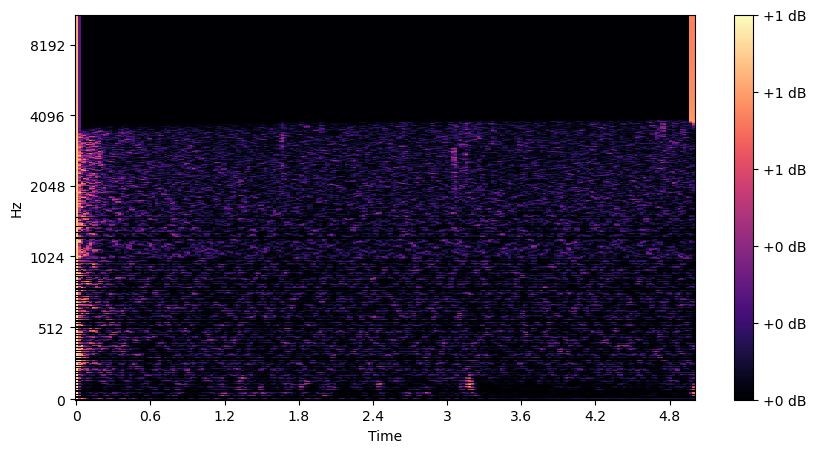

In [14]:
# make a plot of the spectrogram and the predicted bounding box
y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=1025, hop_length=512)
pcen_spectrogram = librosa.pcen(spectrogram * (2**31))
pcen_spectrogram = pcen_spectrogram / np.max(pcen_spectrogram)
plt.figure(figsize=(10, 5))
librosa.display.specshow(pcen_spectrogram, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

width = predicted_bbox[2] - predicted_bbox[0]
height = predicted_bbox[3] - predicted_bbox[1]

if np.any(width > 0) and np.any(height > 0):
    plt.gca().add_patch(plt.Rectangle((predicted_bbox[0], predicted_bbox[1]), width, height, linewidth=1, edgecolor='r', facecolor='none'))